### Python Code for LSM Algorithm: American Option Pricing

In [1]:
import numpy as np
import math
from scipy.special import eval_laguerre
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def laguerre_basis(x,degree):
    '''
    
    Generate a basis of Laguerre Polynomials on X of degree k using built-in scipy functionality
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.eval_laguerre.html#scipy.special.eval_laguerre
    
    Allows for computation of higher order than degree 5 (orig blocker)
    
    '''
    elem=[]
    for i in range (0,degree+1):
        laguerre_i=eval_laguerre(i,x)
        elem.append(laguerre_i)
    basis=np.array(elem).reshape(i+1,len(x)).T
    return basis
                                

### Example Laguerre Basis (scipy)

In [3]:
basis=laguerre_basis(np.ones(10),4)
basis


array([[ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ]])

### LSM Algorithm

Inspiration taken from original MATLAB code constructed by Gustaffson

In [77]:
def LSM(T, r, sigma, K, S0, N, M, k, right=1, seed=1234):
    """
    Longstaff-schwartz method: Gustafsson Implementation
    
    T: Expiration Time 
    r: interest rate
    sigma: underlying vol
    K: strike
    S0: inital underlying
    N: # timesteps from t=0 to t=T
    M: # realizations (even)
    k: basis functions
    seed: random seed for reproducibility
    """

    np.random.seed(seed)
    t = np.arange(0, T, T / N)
    z = np.random.normal(size=(math.floor(M / 2), 1))
    w = (r - (sigma ** 2 / 2)) * T + sigma * np.sqrt(T) * np.vstack([z, -z])
    S = S0 * np.exp(w)
    sup_eb = {}
    inf_eb = {}

    if right == 1:  # put payoffs
        P = np.maximum.reduce([K - S, np.zeros(S.shape)]).reshape(1, -1)[0]
    elif right == 0:  # call payoffs
        P = np.maximum.reduce([S - K, np.zeros(S.shape)]).reshape(1, -1)[0]
    else:
        return

    for i in range(N - 2, 0, -1):
        z = np.random.normal(size=(math.floor(M / 2), 1))
        w = (t[i] * w) / t[i + 1] + sigma * np.sqrt(
            (T / N) * t[i] / t[i + 1]
        ) * np.vstack(
            [z, -z]
        )  # brownian bridge sampling
        S = S0 * np.exp(w)
        if right == 1:
            index = np.where(K > S)[0]
        elif right == 0:
            index = np.where(S > K)[0]
        X = S[index].reshape(1, -1)[0]  # prices and payoffs itm
        Y = P[index] * np.exp(-r * T / N).reshape(1, -1)[0]
        A = laguerre_basis(X, k)  # laguerre basis functions
        x, resid, rank, s = np.linalg.lstsq(A, Y, rcond=None)
        C = A.dot(x.reshape(1, -1)[0])  #  estimated continuation using ols

        if right == 1:
            E = K - X
        elif right == 0:
            E = X - K

        exP = np.where(C <= E)[0]  # indices better to exercise
        
        index_exP = index[exP]
        if len(exP) > 0:
            #sup_price=X[np.where(X[exP]==np.max(X[exP]))[0]]
            sup_price = np.mean(X[exP])
            sup_eb[i] = sup_price

        non_exP = np.where(C >= E)[0]
        if len(non_exP) > 0:
            #inf_price=X[np.where(X[non_exP]==np.min(X[non_exP]))[0]]
            inf_price = np.mean(X[non_exP])
            inf_eb[i] = inf_price

        rest = np.setdiff1d(
            np.arange(0, M), index_exP
        )  # new realizations optimal to exercise

        P[index_exP] = E[exP]  # update payoffs
        P[rest] = P[rest] * np.exp(-r * T / N)

    u = np.mean(P * np.exp(-r * T / N))

    return u, sup_eb, inf_eb


### Comparison against Gustaffson Tests

In [78]:
T=1
r=0.03
sigma=0.15
K=100
S0=90
N=[10+i*10 for i in range(0,19)]
M=10000
k=[2,3,4]

vals=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_p_90,inf_eb_p_90=LSM(T,r,sigma,K,S0,t,M,b)
        vals.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
    bs=[]
ans=np.mean(vals)


Average for 10 is 10.46
Average for 20 is 10.65
Average for 30 is 10.63
Average for 40 is 10.68
Average for 50 is 10.75
Average for 60 is 10.78
Average for 70 is 10.79
Average for 80 is 10.79
Average for 90 is 10.77
Average for 100 is 10.73
Average for 110 is 10.74
Average for 120 is 10.76
Average for 130 is 10.77
Average for 140 is 10.78
Average for 150 is 10.74
Average for 160 is 10.75
Average for 170 is 10.74
Average for 180 is 10.76
Average for 190 is 10.76


In [79]:
ans

10.728067538395374

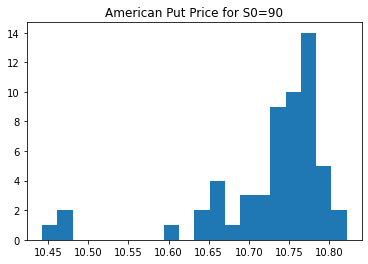

In [80]:
plt.title(f"American Put Price for S0={S0}")
b=plt.hist(vals,bins=20)

In [81]:
T=1
r=0.03
sigma=0.15
K=100
S0=100
N=[10+i*10 for i in range(0,19)]
M=100000
k=[2,3,4]

vals100=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_p_100,inf_eb_p_100=LSM(T,r,sigma,K,S0,t,M,b)
        vals100.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
ans100=np.mean(vals100)

Average for 10 is 4.64
Average for 20 is 4.72
Average for 30 is 4.75
Average for 40 is 4.76
Average for 50 is 4.77
Average for 60 is 4.78
Average for 70 is 4.79
Average for 80 is 4.79
Average for 90 is 4.79
Average for 100 is 4.8
Average for 110 is 4.79
Average for 120 is 4.8
Average for 130 is 4.8
Average for 140 is 4.8
Average for 150 is 4.8
Average for 160 is 4.8
Average for 170 is 4.81
Average for 180 is 4.8
Average for 190 is 4.81


In [82]:
ans100

4.7783734050985265

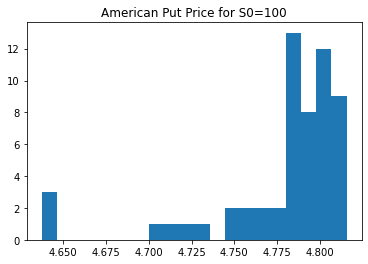

In [83]:
plt.title(f"American Put Price for S0={S0}")
b=plt.hist(vals100,bins=20)

In [84]:
T=1
r=0.03
sigma=0.15
K=100
S0=110
N=[10+i*10 for i in range(0,19)]
M=100000
k=[2,3,4]

vals110=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_p_110,inf_eb_p_110=LSM(T,r,sigma,K,S0,t,M,b)
        vals110.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
ans110=np.mean(vals110)

Average for 10 is 1.77
Average for 20 is 1.8
Average for 30 is 1.81
Average for 40 is 1.82
Average for 50 is 1.82
Average for 60 is 1.83
Average for 70 is 1.83
Average for 80 is 1.83
Average for 90 is 1.83
Average for 100 is 1.83
Average for 110 is 1.84
Average for 120 is 1.84
Average for 130 is 1.84
Average for 140 is 1.84
Average for 150 is 1.84
Average for 160 is 1.84
Average for 170 is 1.84
Average for 180 is 1.84
Average for 190 is 1.84


In [85]:
ans110

1.8261842566866704

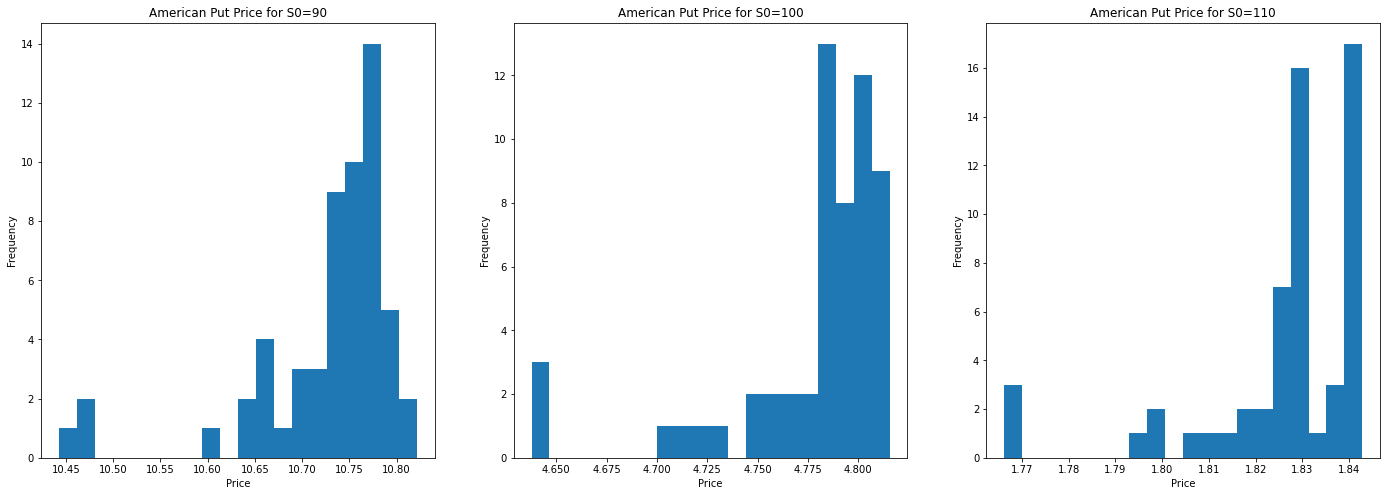

In [86]:
fig,ax=plt.subplots(1,3,figsize=(24,8))

ax[0].set_title(f"American Put Price for S0=90")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")
b=ax[0].hist(vals,bins=20)

ax[1].set_title(f"American Put Price for S0=100")
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Frequency")
b=ax[1].hist(vals100,bins=20)

ax[2].set_title(f"American Put Price for S0=110")
ax[2].set_xlabel("Price")
ax[2].set_ylabel("Frequency")
b=ax[2].hist(vals110,bins=20)

### Computation for the Call

First we compute fair value given Black-Scholes. We can use this to judge the error of our simulation method

In [87]:
def black_scholes_call(T,r,sigma,K,S0):
    
    d1=(np.log(S0/K)+T*(r+0.5*sigma**2))/sigma*np.sqrt(T)
    d2=d1-sigma*np.sqrt(T)
    value=S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
    return value

In [88]:
T=1
r=0.03
sigma=0.15
K=100
S0=90
N=[10+i*10 for i in range(0,19)]
M=10000
k=[2,3,4]
right=0

vals=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_c_90,inf_eb_c_90=LSM(T,r,sigma,K,S0,t,M,b,right)
        vals.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
    bs=[]
ans=np.mean(vals)

Average for 10 is 2.73
Average for 20 is 2.73
Average for 30 is 2.73
Average for 40 is 2.74
Average for 50 is 2.74
Average for 60 is 2.75
Average for 70 is 2.74
Average for 80 is 2.73
Average for 90 is 2.74
Average for 100 is 2.74
Average for 110 is 2.74
Average for 120 is 2.75
Average for 130 is 2.73
Average for 140 is 2.73
Average for 150 is 2.73
Average for 160 is 2.73
Average for 170 is 2.73
Average for 180 is 2.73
Average for 190 is 2.72


In [89]:
ans

2.733615979648948

In [90]:
T=1
r=0.03
sigma=0.15
K=100
S0=90

option_value=black_scholes_call(T,r,sigma,K,S0)
option_value

2.7584438561460694

In [91]:
T=1
r=0.03
sigma=0.15
K=100
S0=100
N=[10+i*10 for i in range(0,19)]
M=10000
k=[2,3,4]
right=0

vals=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_c_100,inf_eb_c_100=LSM(T,r,sigma,K,S0,t,M,b,right)
        vals.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
    bs=[]
ans=np.mean(vals)

Average for 10 is 7.46
Average for 20 is 7.45
Average for 30 is 7.45
Average for 40 is 7.45
Average for 50 is 7.46
Average for 60 is 7.47
Average for 70 is 7.46
Average for 80 is 7.47
Average for 90 is 7.47
Average for 100 is 7.48
Average for 110 is 7.49
Average for 120 is 7.49
Average for 130 is 7.46
Average for 140 is 7.47
Average for 150 is 7.48
Average for 160 is 7.45
Average for 170 is 7.47
Average for 180 is 7.47
Average for 190 is 7.46


In [92]:
ans

7.465795557173732

In [93]:
T=1
r=0.03
sigma=0.15
K=100
S0=100

option_value=black_scholes_call(T,r,sigma,K,S0)
option_value

7.485087593912603

In [94]:
T=1
r=0.03
sigma=0.15
K=100
S0=110
N=[10+i*10 for i in range(0,19)]
M=10000
k=[2,3,4]
right=0

vals=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm,sup_eb_c_110,inf_eb_c_110=LSM(T,r,sigma,K,S0,t,M,b,right)
        vals.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.round(np.mean(bs),2)}")
    bs=[]
ans=np.mean(vals)

Average for 10 is 14.7
Average for 20 is 14.68
Average for 30 is 14.69
Average for 40 is 14.69
Average for 50 is 14.69
Average for 60 is 14.69
Average for 70 is 14.69
Average for 80 is 14.7
Average for 90 is 14.7
Average for 100 is 14.7
Average for 110 is 14.72
Average for 120 is 14.72
Average for 130 is 14.71
Average for 140 is 14.71
Average for 150 is 14.71
Average for 160 is 14.71
Average for 170 is 14.7
Average for 180 is 14.68
Average for 190 is 14.7


In [95]:
ans

14.69809522397599

In [96]:
T=1
r=0.03
sigma=0.15
K=100
S0=110

option_value=black_scholes_call(T,r,sigma,K,S0)
option_value

14.702019669720784

# Min-Max EB 

### Analysis of the Exercise Boundary American Put

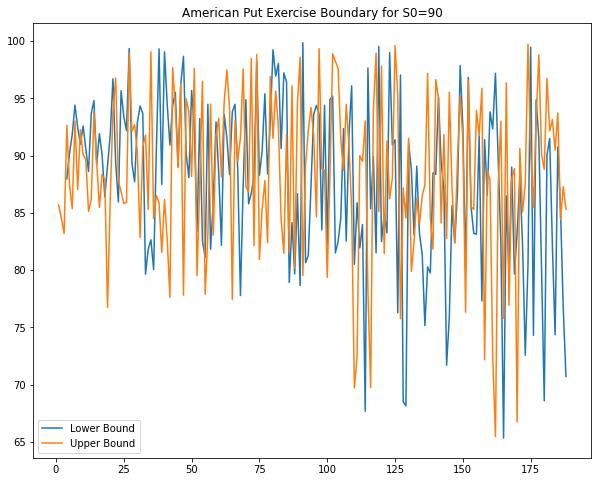

In [24]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=90")
plt.plot(list(sup_eb_p_90.keys()),list(sup_eb_p_90.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_90.keys()),list(inf_eb_p_90.values()),label='Upper Bound')
plt.legend()

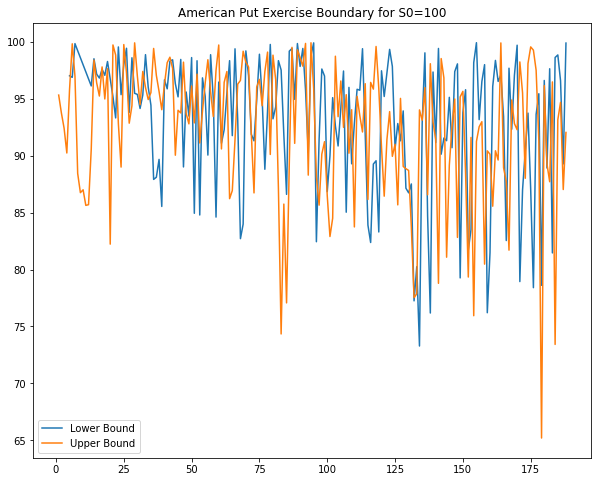

In [25]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=100")
plt.plot(list(sup_eb_p_100.keys()),list(sup_eb_p_100.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_100.keys()),list(inf_eb_p_100.values()),label='Upper Bound')
plt.legend()

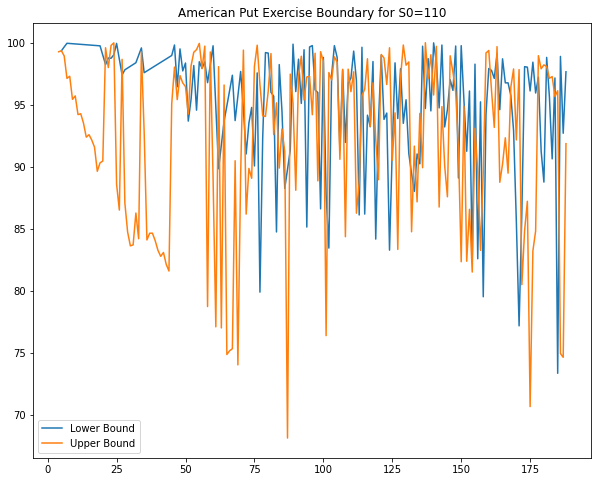

In [26]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=110")
plt.plot(list(sup_eb_p_110.keys()),list(sup_eb_p_110.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_110.keys()),list(inf_eb_p_110.values()),label='Upper Bound')
plt.legend()

### Analysis of the Exercise Boundary American Call

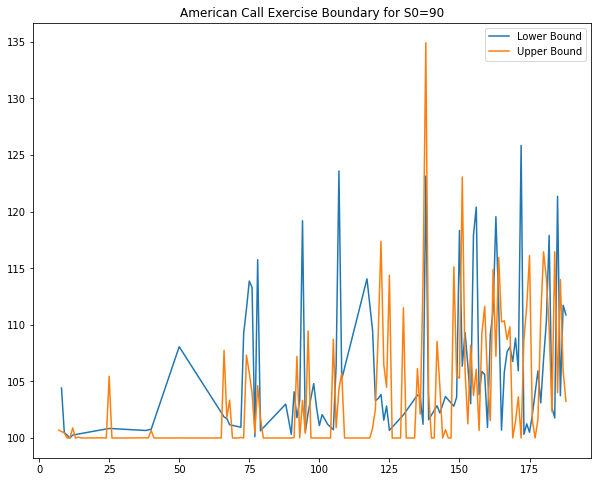

In [27]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=90")
plt.plot(list(sup_eb_c_90.keys()),list(sup_eb_c_90.values()),label='Lower Bound')
plt.plot(list(inf_eb_c_90.keys()),list(inf_eb_c_90.values()),label='Upper Bound')
plt.legend()

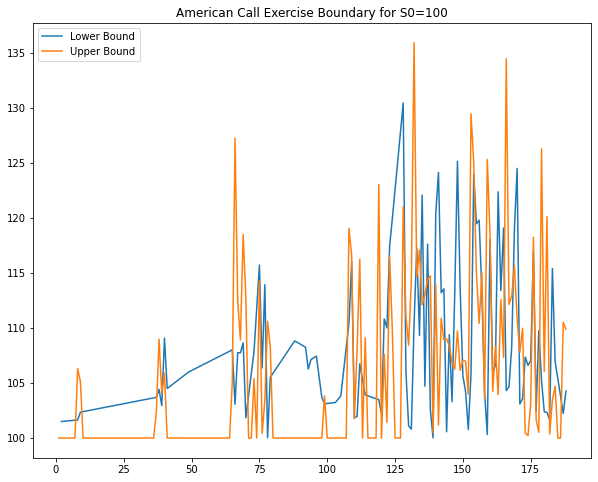

In [28]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=100")
plt.plot(list(sup_eb_c_100.keys()),list(sup_eb_c_100.values()),label='Lower Bound')
plt.plot(list(inf_eb_c_100.keys()),list(inf_eb_c_100.values()),label='Upper Bound')
plt.legend()

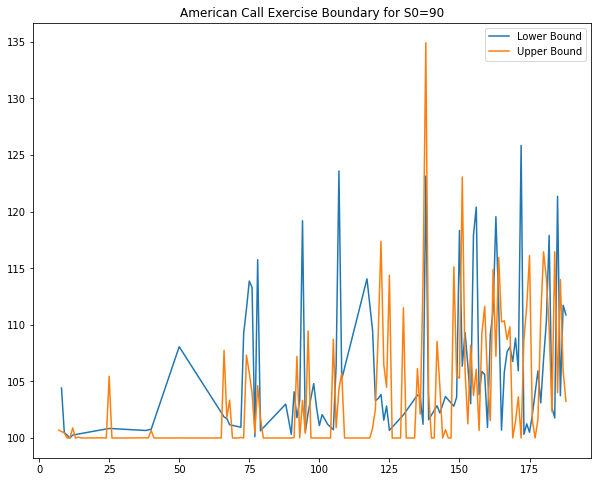

In [29]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=90")
plt.plot(list(sup_eb_c_90.keys()),list(sup_eb_c_90.values()),label='Lower Bound')
plt.plot(list(inf_eb_c_90.keys()),list(inf_eb_c_90.values()),label='Upper Bound')
plt.legend()

# Sample Mean EB

### Analysis of the Exercise Boundary American Put

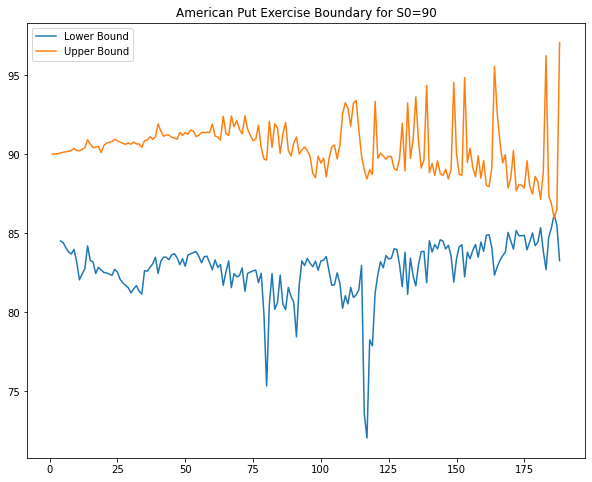

In [97]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=90")
plt.plot(list(sup_eb_p_90.keys()),list(sup_eb_p_90.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_90.keys()),list(inf_eb_p_90.values()),label='Upper Bound')
plt.legend()

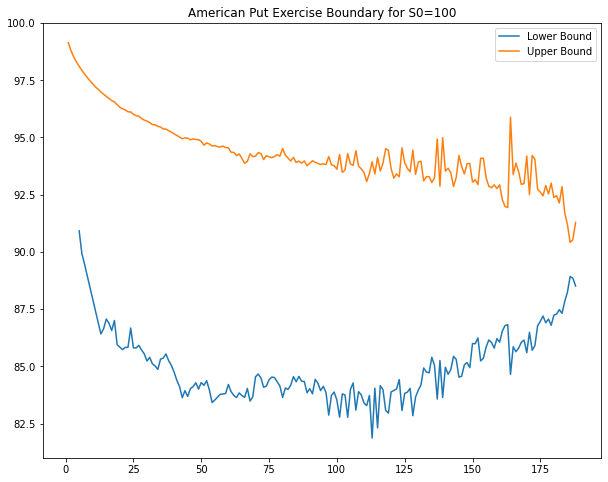

In [98]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=100")
plt.plot(list(sup_eb_p_100.keys()),list(sup_eb_p_100.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_100.keys()),list(inf_eb_p_100.values()),label='Upper Bound')
plt.legend()

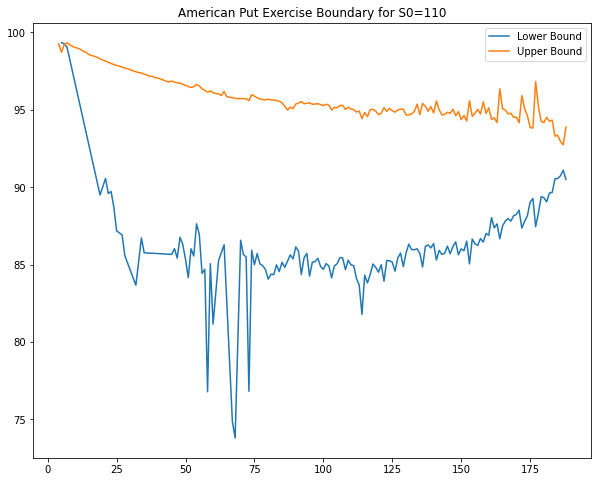

In [99]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Put Exercise Boundary for S0=110")
plt.plot(list(sup_eb_p_110.keys()),list(sup_eb_p_110.values()),label='Lower Bound')
plt.plot(list(inf_eb_p_110.keys()),list(inf_eb_p_110.values()),label='Upper Bound')
plt.legend()

### Analysis of the Exercise Boundary American Call

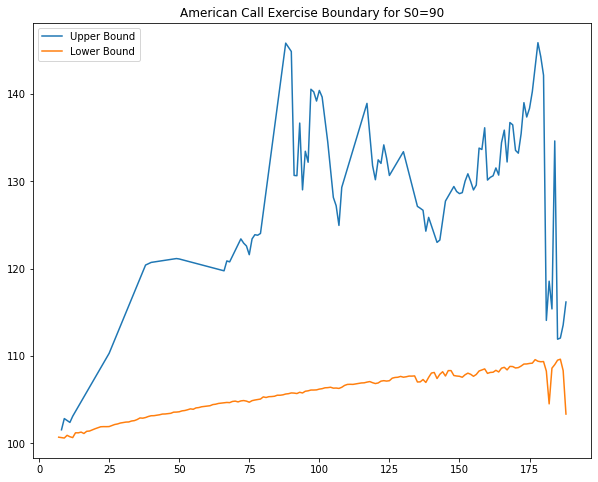

In [103]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=90")
plt.plot(list(sup_eb_c_90.keys()),list(sup_eb_c_90.values()),label='Upper Bound')
plt.plot(list(inf_eb_c_90.keys()),list(inf_eb_c_90.values()),label='Lower Bound')
plt.legend()

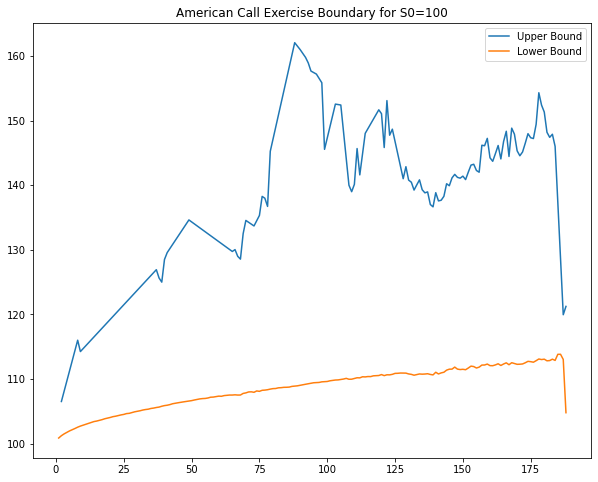

In [104]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=100")
plt.plot(list(sup_eb_c_100.keys()),list(sup_eb_c_100.values()),label='Upper Bound')
plt.plot(list(inf_eb_c_100.keys()),list(inf_eb_c_100.values()),label='Lower Bound')
plt.legend()

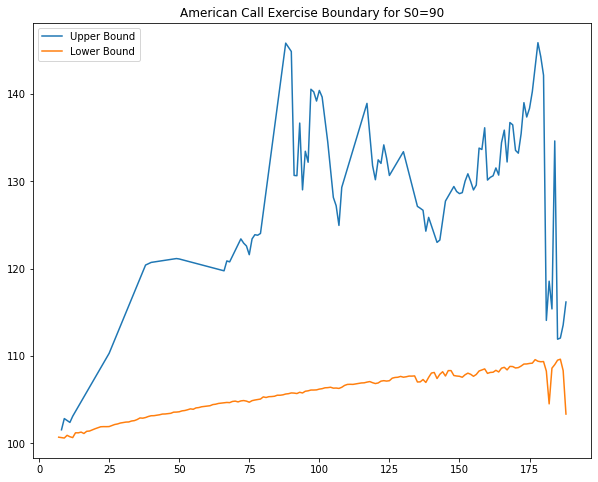

In [105]:
fig,ax=plt.subplots(figsize=(10,8))
plt.title("American Call Exercise Boundary for S0=90")
plt.plot(list(sup_eb_c_90.keys()),list(sup_eb_c_90.values()),label='Upper Bound')
plt.plot(list(inf_eb_c_90.keys()),list(inf_eb_c_90.values()),label='Lower Bound')
plt.legend()